# Email Tracking BOT Detection - Data Exploration

![alt text](Diagrams/Tracking.png "Tracking Overview") 

More and more, email tracking data is originating from BOT activity as opposed to the actual person the email is intended for.  Through manual investigation, most of these bots are not malicious, but come from protective services like Anti-Phishing devices meant to protect the email contact from dangerous emails.  

The goal is not to reject requests from known BOTS.  We still want these protective services to see the links and to be able to judge the safety of the email message.  But if we can predict if the request is from one of these BOT services, we could mark or discard the activity to prevent skewing of activity reporting on the campaign.

## Terminology
- **Subscriber List** - A list of email addresses that have opted into receiving emails from the company.  A list have have many emails.  A company can have many subscriber lists.  An email can belong to many lists and many companies.  But a subscriber list can only belong to one company.
- **Campaign** - An email message send out by a company.  This email is sent to some or all the subscribers on the list.  With the exception of some limited personalization, all subscribed receive the same content.  A list can have many campaigns, but a campaign can only have one subscriber list.
- **Inbox** - What the contact sees as a unique message in their inbox (Outlook, GMail, etc.).  If a company sends a single campaign to 1 million contacts, there will be 1 million InboxIDs for that campaign.
- **Request** - A tracking HTTP request from an action the contact takes on a message in their inbox.  There are several types of requests, but they are primarily Opens which are pixel image reqeusts and Clicks.
- **Link** - A clickable and trackable URL embedded in the email message.  The tracking system identifies the click, saved the tracking information and returns a redirect URL so the contact gets to their intended URL destination.
- **AS Number/Name** - Who owns the block of IP address.  https://en.wikipedia.org/wiki/Autonomous_system_(Internet)
- **CIDR** - A notation of shows us what range of IP address are in a block. https://en.wikipedia.org/wiki/Classless_Inter-Domain_Routing


## Columns 

 #### Raw columns recieved with HTTP Request:
 
 - **InboxID** - Uniquely identifies the Campaign and the email it was sent to.
 - **Company** - Who owns the campaign
 - **RequestType** - 
     - *Open* - The contact downloaded images for the message.  A tracking pixel added to the HTML body of the message makes a request to the tracking system to identify who opened the message.
     - *Read* - The message was opened for a pre-defined period of time.
     - *Click* - The contact clicked on a URL in the message and the tracking system sees this request.
     - *Browser Link* - The contact requested seeing the message in a web browser.  Mostly used if the message did not render well in the email client.
 - **RequestDate** - The date of the reqeust (i.e. Open or Click).
 - **Link** - A hash of the URL requested.
 - **IPAddress** - The IP Address the requested was generated from.
 - **UserAgent** - A string submitted by email clients/browsers and Bots that attempts to identify the browser type.  This can be made any string you want to it can be easily modified by Bots.
 
 
 #### Columns that can be looked up from the InboxID: 
 
 - **SendDate** - The date and time (1 minute precision) of when the message was sent to that email.  If a company sends a campaign to 5 million email, the send might take 10-20 mins.  The SendDate is the date when that message was sent out and not the date the campaign started.
 - **List** - A unique ID of the subscription list.  
 - **Campaign** - A unique ID of the campaign.
 - **UserID** - A unique ID of the email address the message was sent to.
 - **DomainID** - A unique ID of the domain of the email address the message was sent to.
 - **EmailDomain** (redundant with DomainID)- A unique ID of the domain of the email address the message was sent to.
 - **EmailRootLevelDomain** - The top level domain of the email domain.  i.e. fred@gamil.com - ".com", mary@harvard.edu - 
 
 
 #### Columns that are derived from IP lookup data:
 
 - **AS Name** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **AS Number** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **CIDR Range** - The block the IPAddress belongs to (see above).  Can be Null if owner not found in ASN database.".edu"
 - **Lat/Long** - Found from an IP Lookup service.  Data available is not center of mass, but just the first Lat/Log in the polygon.
 - **OlsonName** - Time Zone of the location the request came from. Also found via the IP Lookup.
 
#### Cacluated columns after InboxID lookup is performed
 
 - **SendRequestSeconds** - Number of seconds between the time the message was sent to the request date..


 ## Hierarchies in Data
 
 ![alt text](Diagrams/Hierarchies.png "Hierarchies in Data")

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import pytz
from dateutil.tz import tzutc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

## SingleCampaignClicksWithKnownBotActivity.csv

This particular data set is from a single campaign and only looking at the Click requests.  It was discovered this this and a few other accounts tend to have large number of click requests comming in even before the send is finished sending.  

So the goal is to first examain the data from a single campaign from one of these accounts to do data exploration and possible as training data.  

Other campaings from this test account can then be used at testing any predictive algorighms.

In addition, looking at other Reqeusts Types like Opens and Browser Links can be looked at.

### BotDataSet Class

We will use a class to load and build caculated columns.  This will allow us to reuse code when we look at traing and testing datasets.

In [2]:
exec(open("BotDataSet.py").read())

ds = BotDataSet()
ds.loadCSV('C:/data/SingleCampaignClicksWithKnownBotActivity.csv')
df = ds.df

In [3]:
pd.options.display.max_columns = None
display(df.head()) 
df.nunique()

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestSeconds,SendRequestSeconds_ln
0,{8371576A-141A-D149-9325-48155E7E3A27},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{9D2183D8-58EF-62C7-0DBB-F9918666FA36},{34DE7234-0FA5-9494-8BA9-8014CFCCEA0A},{98E4A6A4-80AE-82A0-3E5C-14C741704C4B},Unknown,Unknown,{4B129F96-9D01-F78E-4035-28B9E0116C45},{3674441B-D84D-4B34-6912-D0A928C0620A},{2DB770D2-99CB-42BE-9D96-DFF1DD6E6844},{C3EE0A7B-9FDB-7705-0CCF-9865BCE9429E},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
1,{8371576A-141A-D149-9325-48155E7E3A27},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{8EE998D4-D1E3-5F35-0BF1-DB8F2AADA844},{3BEE9B6C-B1A0-CF0D-63D3-57835C41F896},{98E4A6A4-80AE-82A0-3E5C-14C741704C4B},Unknown,Unknown,{4B129F96-9D01-F78E-4035-28B9E0116C45},{3674441B-D84D-4B34-6912-D0A928C0620A},{2DB770D2-99CB-42BE-9D96-DFF1DD6E6844},{C3EE0A7B-9FDB-7705-0CCF-9865BCE9429E},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
2,{8371576A-141A-D149-9325-48155E7E3A27},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{71932D0F-822A-E46A-0034-2DE710FA81C6},{FFFD8012-9264-C188-0AE1-9A11C86D6350},{98E4A6A4-80AE-82A0-3E5C-14C741704C4B},Unknown,Unknown,{4B129F96-9D01-F78E-4035-28B9E0116C45},{3674441B-D84D-4B34-6912-D0A928C0620A},{2DB770D2-99CB-42BE-9D96-DFF1DD6E6844},{C3EE0A7B-9FDB-7705-0CCF-9865BCE9429E},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
3,{8371576A-141A-D149-9325-48155E7E3A27},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{EAE116EC-B1BB-2AF3-4DB0-46923C7D3A71},{7D8CBA4C-E9E6-4EB1-3E51-758F2738A095},{98E4A6A4-80AE-82A0-3E5C-14C741704C4B},Unknown,Unknown,{4B129F96-9D01-F78E-4035-28B9E0116C45},{3674441B-D84D-4B34-6912-D0A928C0620A},{2DB770D2-99CB-42BE-9D96-DFF1DD6E6844},{C3EE0A7B-9FDB-7705-0CCF-9865BCE9429E},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
4,{3525FA52-187F-9315-3263-90C3F414F79B},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{7CB36D9F-C483-3A19-63CE-50C3F925D5F2},{0922ED01-E279-C550-47F0-752AC5E5245B},{EF41C93D-5AA6-BFEE-A6B5-740EBFF5A478},"Amazon.com, Inc.",16509,{39E09C6D-0B20-4791-56E0-1B83B48A7C2A},{1E73A4CF-7A06-63CD-F259-1A7FDFE1B606},{7E58739D-6BCD-F7CA-FE5C-8389A3061C31},{2E9DCE26-9B42-EF7F-DAAA-1F842385D09A},.org,US,OR,97207,45.850021,-119.631154,America/Los_Angeles,0,1.0


InboxID                  11566
Company                      1
List                         1
Campaign                     1
RequestType                  1
SendDate                    13
RequestDate               2187
Link                        37
IPAddress                10339
UserAgent                 1181
AS Name                     21
AS Number                   22
CIDR Range                 354
UserID                   11566
DomainID                   952
EmailDomain                952
EmailRootLevelDomain        32
CountryCode                 77
RegionCode                 148
PostalCode                2572
Lat                       1612
Long                      1659
OlsonName                   79
SendRequestSeconds        2180
SendRequestSeconds_ln     2180
dtype: int64

# Only One Metrizable Column in Raw Request Data
## This shows a large percent of clicks occur within seconds of the send

With manual lookup, it was found that a very high percent of the click activity in the first few seconds after the send is from suspected BOTs.  This makes sense, if the BOT is an Anti-Phishing or Anti-Malware service, they will want to analyze the message as soon as it is received so that there is not a delay in putting the message into the contact's inbox.

In fact, this behavior is how BOT activity was discovered.  The number of click requests that were coming as the campaign is still finishing the send was causing resource contention on the tracking web servers.  The resource contention is very short lived and only last 1 or 2 minutes.

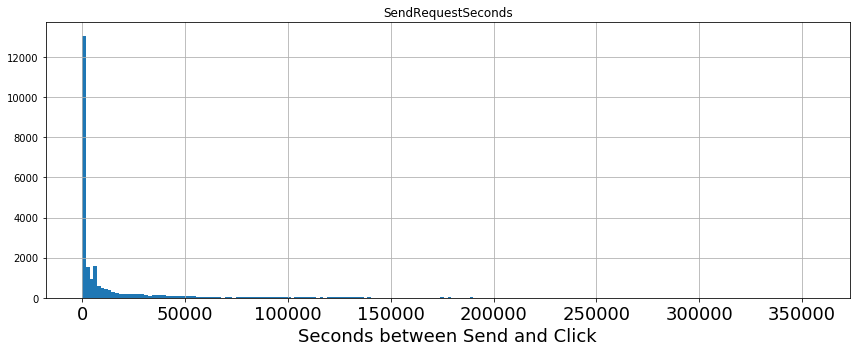

In [4]:
df.hist(column='SendRequestSeconds', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Seconds between Send and Click", fontsize=18)
plt.tight_layout()
plt.show()

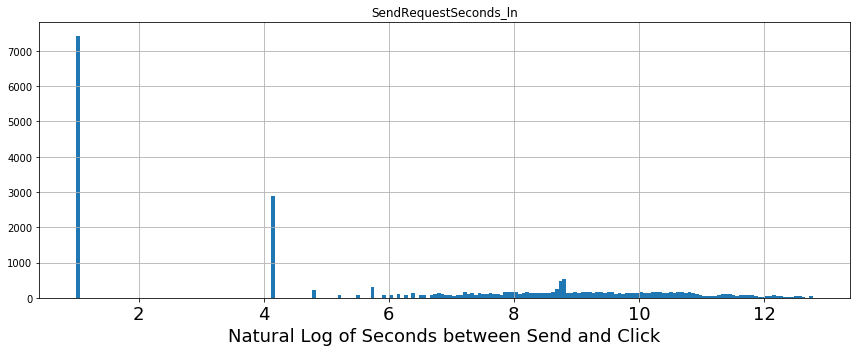

In [5]:
df.hist(column='SendRequestSeconds_ln', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Natural Log of Seconds between Send and Click", fontsize=18)
plt.tight_layout()
plt.show()

# Sessionization

Making assessments from individual requests may not be as informative as grouping requests together.  It is common for a single InboxID to have multiple requests (i.e. click 3 links on the same message in your inbox). 
 
For example, 20 minutes after a message was put into a contact's inbox, they might open the message (pixel request) followed by 3 or 4 link clicks.  That same contact might go back to that same message the following day and click on several more links.
 
It might be more suspicious that requests are from a BOT if 20 clicks come in for the same InboxID in under 3 seconds or if the same IP Address requests opens from 50 different InboxIDs in a short period of time.

There are 2 things needed to determine a session.  The first is how to partition or group the data.  Examples of could be to partition on InboxID or IPAddress.

The second is some kind of time frame algorithm.  The algorithm chosen here includes all requests for the given partition as long at duration between requests doesn't exceed a set gap. This requires a datetime column (in case, the RequestDate) and a max gap allowed.


![alt text](Diagrams/Sessionization.png "Sessionization")


## Extend Dataframe with Session Columns

#### We want to sessionize in 2 ways, the InboxID and the IP Address

- **InboxID** - This is straight forward.  Any requests from the same inbox message will have the same session if there are not any gaps over 2 mins.  This type of session will be used to judge behavior of the "Contact".
- **IP Address** - This type of sessionization will be used to judge the behavior of where the requests come from.  If I click links from 2 different messages, the 2 InboxIDs will come from the same IP Address.  But it might be unusual to have requests from many different InboxIDs from the same IP. Especially if the inboxes are to different emails and different email domains.
- **CIDR Range** - Creating session based on a block of IP addresses might be more valuable than just the Single IP Address.  If the BOT activity is coming from a larger company, they may use dozens or even hundreds of IPs.
- **AS Number** - The ASN is a grouping of CIDR Ranges owned by the same company.  So the advantages we might get from using CIDR ranges over a single IP might be amplified with the ASN.  But we also run the risk of getting multiple companies within the same AS Number.  Amazon Web Services owns hundreds of CIRD Ranges.  Any account that uses AWS to host their application might share the same AWS ASN.  We will look at sessionizing on the ASN, but this might lead to too many false positives.

**NOTE:**  CIDR Range and ASN are only available for about 1/2 of the rows in this dataframe.  The AS database used to match IP Address to the AS hierarchy  only contains data for the biggest owners of IP Addressed.


Below, we use the BotDataSet class to append session columns to our dataframe.

In [6]:
max_session_time_gap = timedelta(seconds=120)

session_columns = {'InboxID':'InboxSessionID',
                   'IPAddress':'IPSessionID', 
                   'CIDR Range':'CIDRSessionID', 
                   'AS Number':'ASNSessionID' }

for t in session_columns.items():
    ds.loadSessionColumn(t, max_session_time_gap)

df = ds.df

In [7]:
display_columns = ['RequestDate', 'InboxID', 'IPAddress', 'CIDR Range', 'AS Number']
display_columns.extend(list(session_columns.values()))

sdf = df[display_columns]
display(sdf.head()) 
sdf.nunique()

,RequestDate,InboxID,IPAddress,CIDR Range,AS Number,InboxSessionID,IPSessionID,CIDRSessionID,ASNSessionID
0,2020-01-17 09:03:00,{8371576A-141A-D149-9325-48155E7E3A27},{34DE7234-0FA5-9494-8BA9-8014CFCCEA0A},{4B129F96-9D01-F78E-4035-28B9E0116C45},Unknown,-7184706677959476423,6387038179731913895,4844686556600034661,660980076888813864
123,2020-01-17 09:03:00,{D946D70D-4FFD-F2D1-4F3E-BE3A3FFAA4D9},{EDF2D82A-284E-A32C-A42E-4A3D548B45E2},{B7291AFA-E72B-6D78-0145-A05588DEBF8A},16509,9008611293421902341,-5460667053234248860,1038978480080318945,-4740939799344978521
70,2020-01-17 09:03:00,{075E080C-AC5F-F151-496F-143B6F9B5D34},{67E5F031-D54C-64EA-0412-E35F5E86B927},{6C682CAC-2C56-2A76-ECD7-2A83E958CF48},16509,5886414566895322420,-7133802589488409043,-6280045166365835806,-4740939799344978521
1,2020-01-17 09:03:00,{8371576A-141A-D149-9325-48155E7E3A27},{3BEE9B6C-B1A0-CF0D-63D3-57835C41F896},{4B129F96-9D01-F78E-4035-28B9E0116C45},Unknown,-7184706677959476423,1161901819118210845,4844686556600034661,660980076888813864
2,2020-01-17 09:03:00,{8371576A-141A-D149-9325-48155E7E3A27},{FFFD8012-9264-C188-0AE1-9A11C86D6350},{4B129F96-9D01-F78E-4035-28B9E0116C45},Unknown,-7184706677959476423,2423124589834599170,4844686556600034661,660980076888813864


RequestDate        2187
InboxID           11566
IPAddress         10339
CIDR Range          354
AS Number            22
InboxSessionID    12398
IPSessionID       11532
CIDRSessionID      2078
ASNSessionID       1227
dtype: int64

## IP Based Session DataFrames

We need to build 3 new DataFrames via the Pandas groupby function.  

These aggregate DataFrames are based on the IP hierarchy and hold the "SessionID" column as the index with aggregate values.

The goal is to build a BOT Score for each of these 3 IP hierarchy levels and merge them back into the original DataFrame.

 ![alt text](Diagrams/MergingSessionDataFrames.png "Merging Session DataFrames")

In [8]:
df_IPSession = df.groupby(['IPSessionID']).agg({
                                                   'IPSessionID':'count',
                                                   'IPAddress':'min',
                                                   'InboxID':'nunique', 
                                                   'UserID':'nunique', 
                                                   'EmailDomain':'nunique', 
                                                   'EmailRootLevelDomain':'nunique',
                                                   'Link':'nunique',
                                                   'SendRequestSeconds':'mean', 
                                                   'SendRequestSeconds_ln' : 'mean',
                                                   'RequestDate':lambda x: (x.max() - x.min()).seconds
                                                    })
df_IPSession.rename(columns={"IPSessionID": "ReqeustCount", 
                         "InboxID": "UniqueInboxIDs", 
                         "UserID": "UniqueEmails", 
                         "EmailDomain": "UniqueEmailDomains", 
                         "EmailRootLevelDomain": "UniqueEmailRootLevelDomain", 
                         "Link": "UniqueLinks",  
                         "SendRequestSeconds": "MeanSendRequestSeconds", 
                         "SendRequestSeconds_ln": "MeanSendRequestSeconds_ln", 
                         "RequestDate": "SessionDuration"}, 
                inplace=True)
df_IPSession.sort_values(['UniqueInboxIDs'], ascending=False, inplace=True)
# display(df_IPSession.head(10)) 

# K Means on IP GroupBy DataFrames

## IP Session

In [9]:
agg_columns = ['ReqeustCount',
               'UniqueInboxIDs',
               'UniqueEmails',
               #'UniqueEmailDomains',
               'UniqueEmailRootLevelDomain',
               'UniqueLinks',
               #'MeanSendRequestSeconds',
               'MeanSendRequestSeconds_ln',
               'SessionDuration']



# Make sure the reduced columns is it's own df is not a view
df_IPSession_agg = df_IPSession[agg_columns].copy()

# Index is 'IPSessionID' which we will use to map back to our origional DataFrame so we can append the KMeanLables we find
print(df_IPSession_agg.index.name)

IPSessionID


## Start K-Means

### Scaler
Here we picked the MinMax Scaler to normalize our aggregate columns.
Note: SendRequestSeconds's PDF is an expoential decay curve.  Since we already have the natual log of column, the min max scaler should still be a good fit.

In [10]:
mms = MinMaxScaler()
mms.fit(df_IPSession_agg)
df_IPSession_transformed = pd.DataFrame(mms.transform(df_IPSession_agg))
df_IPSession_transformed.columns = agg_columns
df_IPSession_transformed.index = df_IPSession_agg.index

# Index is 'IPSessionID' which we will use to map back to our origional DataFrame so we can append the KMeanLables we find
print(df_IPSession_transformed.index.name)

IPSessionID


### Find # of Clusters to use in the Model
Find the best guess at to the number of clusters to use to ploting sq mean distances of the clusters as we walk the cluster count from 1 to 15

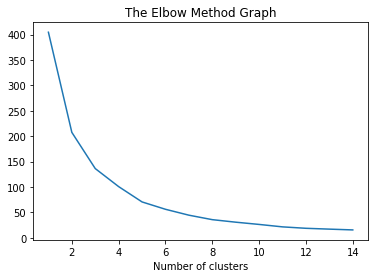

In [11]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_IPSession_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(range(1,15),Sum_of_squared_distances)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.show()

## We see a change in slope around 5

But there is not an obvious elbow, so we could have picked 3 or 4

### Instantiate the KMeans class with clusters = 5
Run fit and get the ndarray of the predicted lables

We will use this array to append a new series onto existing DataFrames

In [12]:
model = KMeans(n_clusters=5)
model.fit(df_IPSession_transformed)
labels = model.predict(df_IPSession_transformed)

print(labels[:80])

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 1 0 0 0 0 2 0 0 0
 2 0 0 0 0 0]


#### Make sure the indexes and cardinality of the DataFrames and K-Means lables are a match

In [13]:
print("\
Index of transformed = {}\n\
Index of agg = {}"
      .format( 
              df_IPSession_transformed.index.name, 
              df_IPSession_agg.index.name
             ))

print("\
Len of transformed = {}\n\
Len of agg = {}\n\
Len of lables = {}"
      .format( 
              len(df_IPSession_transformed), 
              len(df_IPSession_agg), 
              len(labels)
              ))

Index of transformed = IPSessionID
Index of agg = IPSessionID
Len of transformed = 11532
Len of agg = 11532
Len of lables = 11532


## Merge KMean Lables for the IP GroupBy back into the 2 DataFrames

In [14]:
df_IPSession_transformed['IP_KMean'] = labels
df_IPSession_agg['IP_KMean'] = labels

## Show custering results in pair plot

#### Split pair plots into 2 for better visibility

In [15]:
#todo: np.seterr(divide='ignore', invalid='ignore')
# Find out what the warnning is about.  i.e. More cleanup on MeanSendRequestSeconds_ln
np.seterr(divide='ignore', invalid='ignore') 

sns.set_context(font_scale=2)  

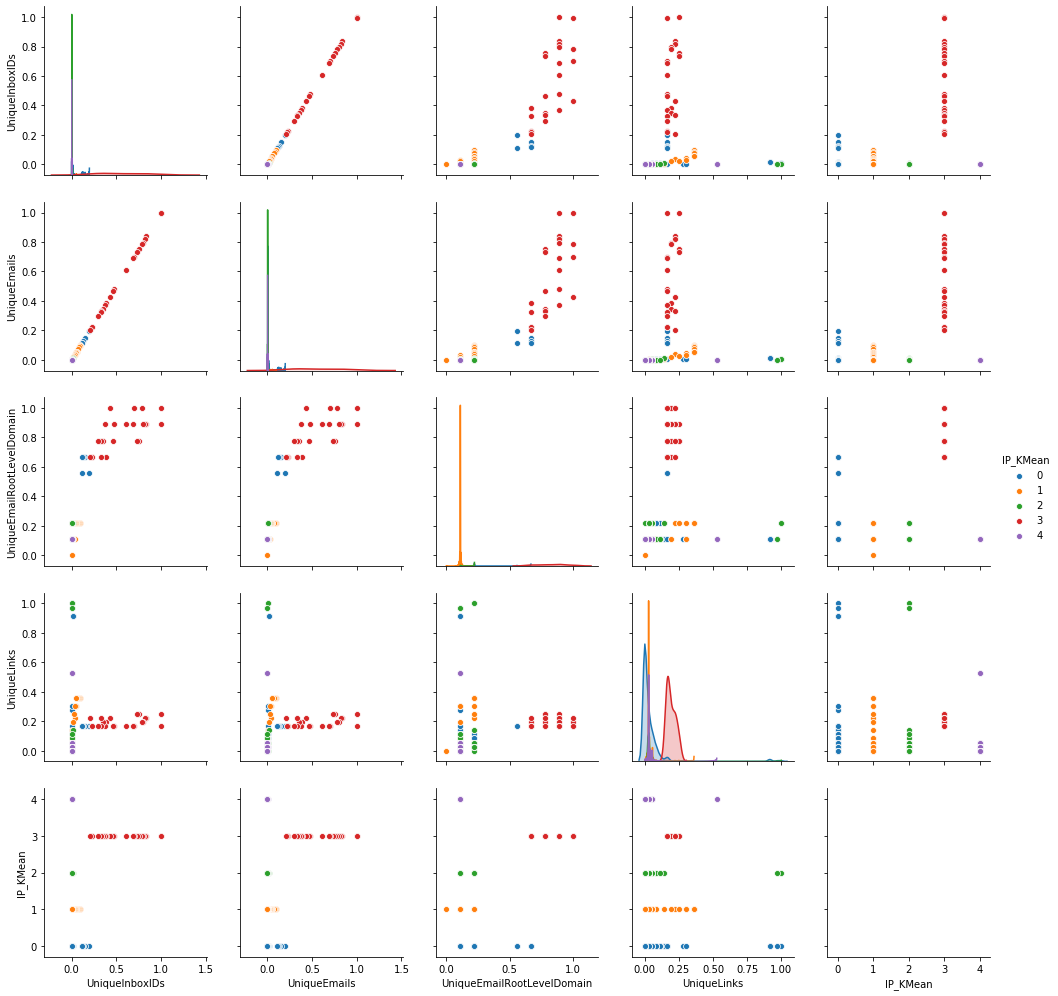

In [16]:
first_columns = ['UniqueInboxIDs', 'UniqueEmails', 'UniqueEmailRootLevelDomain', 'UniqueLinks', 'IP_KMean']
sns.pairplot(df_IPSession_transformed[first_columns], hue="IP_KMean", height=2.8)

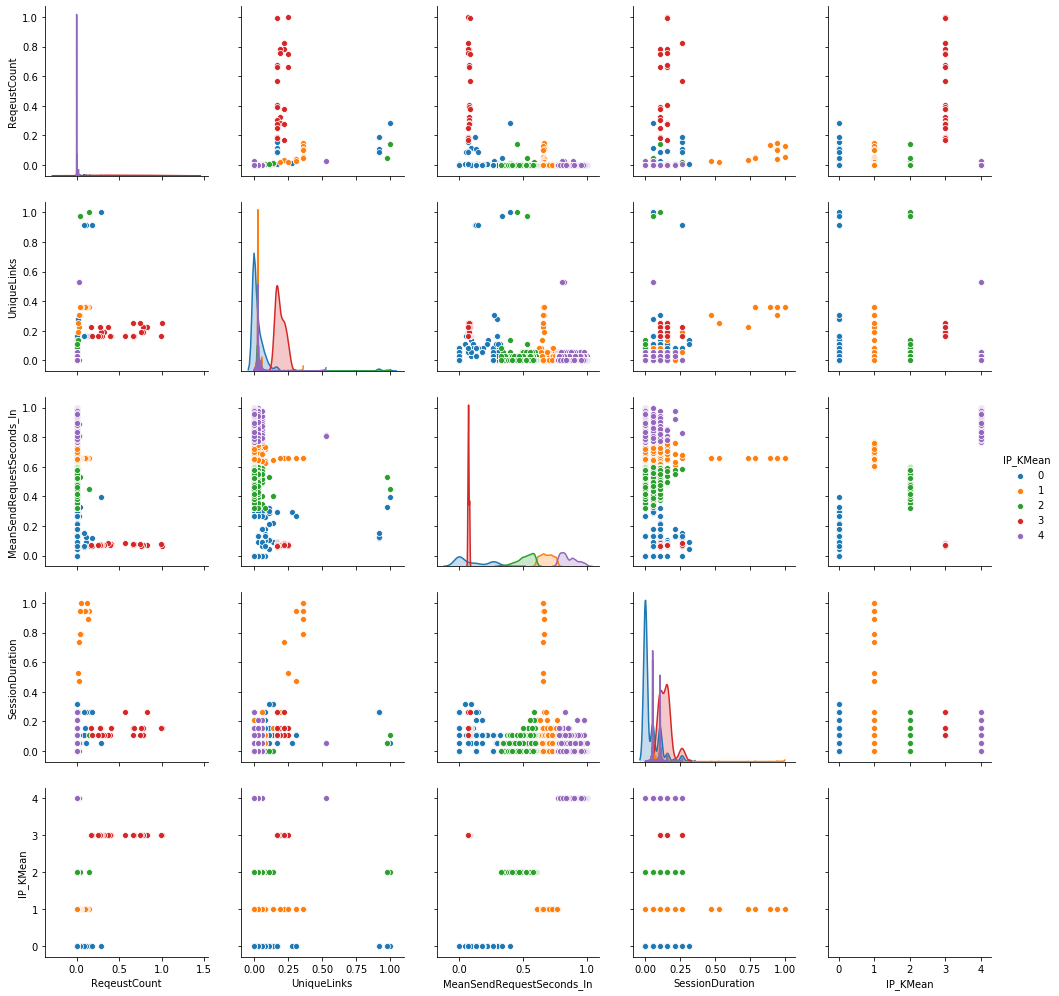

In [17]:
second_columns = ['ReqeustCount', 'UniqueLinks', 'MeanSendRequestSeconds_ln', 'SessionDuration', 'IP_KMean']
sns.pairplot(df_IPSession_transformed[second_columns], hue="IP_KMean", height=2.8)

# Merge the K-Means labels for IP GroupBy with original df

In [18]:
df_IPKMeans = pd.merge(df, df_IPSession_agg['IP_KMean'], on="IPSessionID")

## Show distribution of these labels across the AS Names

In [19]:
g = df_IPKMeans.groupby(['IP_KMean', 'AS Name'])['AS Name'].count()
g = pd.DataFrame(g)
g.columns = ['Count']
g.sort_values('Count', ascending=False)
g.reset_index('IP_KMean', inplace=True)
g.pivot(columns='IP_KMean', values='Count')

IP_KMean,0,1,2,3,4
AS Name,,,,,
AT&T Mobility LLC,1.0,486.0,293.0,NaN,338.0
"Amazon.com, Inc.",875.0,815.0,189.0,9181.0,79.0
Cellco Partnership DBA Verizon Wireless,NaN,2.0,NaN,NaN,1.0
"CenturyLink Communications, LLC",NaN,33.0,25.0,NaN,33.0
Cogent Communications,NaN,1.0,1.0,NaN,NaN
"Comcast Cable Communications, LLC",NaN,38.0,17.0,NaN,26.0
"DigitalOcean, LLC",36.0,3.0,15.0,NaN,2.0
DoD Network Information Center,NaN,NaN,3.0,NaN,NaN
GENESCO INC,NaN,4.0,2.0,NaN,NaN
